In [1]:
#imports
from pathlib import Path

#file paths
ROOT = ROOT = Path.cwd().parent
RAW_DIR = ROOT/"data"/"raw"
PROCESSED_DIR = ROOT/"data"/"processed"

import sys, os
import pandas as pd
import numpy as np

sys.path.insert(0, os.path.abspath("..")) #preprocess at root
from preprocess import load_csv, save_csv, gini

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text
print("Imports loaded")

Imports loaded


In [2]:
#1.1 load data
"""
Data cleaned in previous assignments. Load cleaned data directly
Cleaned data contains:
    NaN filled with 0
    regex normalization (spaces, lowercase,etc)
    churn to binary (1=churn, 0=not)
"""

df_clean = load_csv(PROCESSED_DIR, "data03_cleaned.csv")
total_charges = pd.to_numeric(df_clean.totalcharges, errors='coerce') #reconvert data type. pandas infers incorrectly from csv

print("Data")
display(df_clean.head().T) #transpose rows/cols to make viewing easier
print("\nDataTypes:")
display(df_clean.dtypes)

Loaded data03_cleaned.csv: length: 7043 

Data


,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no



DataTypes:


customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

In [3]:
#1.2 split features 'X' and target 'y' (churn=1 or not-churn=0). KMeans only applied to features
y = df_clean['churn'].values #target

df_features = df_clean.drop(['customerid', 'churn'], axis=1) #drop id and target

print("Features", df_features.head().T)

Features                                  0             1               2  \
gender                      female          male            male   
seniorcitizen                    0             0               0   
partner                        yes            no              no   
dependents                      no            no              no   
tenure                           1            34               2   
phoneservice                    no           yes             yes   
multiplelines     no_phone_service            no              no   
internetservice                dsl           dsl             dsl   
onlinesecurity                  no           yes             yes   
onlinebackup                   yes            no             yes   
deviceprotection                no           yes              no   
techsupport                     no            no              no   
streamingtv                     no            no              no   
streamingmovies                 no     

In [4]:
#1.3 find object (categorical) columns
print("Object Types")
print(df_features.dtypes)

cat_cols = df_features.select_dtypes(include=['object']).columns.tolist()
print("\nObject Columns:", cat_cols)

Object Types
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
dtype: object

Object Columns: ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']


In [5]:
#1.4 split data
#shuffle and split 20% test, 80% train
X_train_full, X_test = train_test_split(df_clean, test_size=0.2, random_state=1)

#train/validation split
X_train, X_val = train_test_split(X_train_full, test_size=0.33, random_state=11)

print("df train")
display(X_train.head())
print("\ndf val")
display(X_val.head())
print("\ndf test")
display(X_test.head())

#confirm shapes
print("\nInitial Shapes:")
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

#save churn as target
y_train = X_train.churn.values
y_val = X_val.churn.values

#delete churn col - don't use for training
del X_train['churn']
del X_train['customerid']
del X_val['churn']
del X_val['customerid']
del X_test['churn']
del X_test['customerid']

#confirm shapes after drop
print("\nFinal Shapes:")
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

df train


,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
2935,9435-jmlsx,male,0,yes,no,71,yes,no,dsl,yes,...,yes,yes,yes,yes,two_year,yes,bank_transfer_(automatic),86.10,6045.90,0
3639,0512-flfdw,female,1,yes,no,60,yes,yes,fiber_optic,no,...,yes,no,yes,yes,one_year,yes,credit_card_(automatic),100.50,6029.00,0
2356,3450-wxoat,male,0,no,no,46,yes,no,dsl,no,...,no,no,no,no,month-to-month,yes,credit_card_(automatic),45.20,2065.15,0
6660,1447-giqmr,male,0,yes,no,1,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,69.15,69.15,1
755,6683-vlctz,male,1,no,no,20,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,98.55,1842.80,1



df val


,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
5805,1697-nvvgy,male,1,yes,no,19,yes,no,dsl,yes,...,yes,no,yes,no,month-to-month,no,bank_transfer_(automatic),66.40,1286.05,0
3687,6849-oyamu,male,0,yes,yes,19,yes,no,fiber_optic,no,...,no,yes,yes,yes,one_year,no,bank_transfer_(automatic),100.00,1888.65,1
6900,7921-lmdfq,male,1,no,no,51,yes,no,fiber_optic,no,...,yes,no,yes,yes,one_year,yes,bank_transfer_(automatic),94.00,4905.75,0
1644,3331-hqdtw,female,0,no,no,34,yes,yes,fiber_optic,yes,...,yes,no,yes,yes,month-to-month,yes,mailed_check,109.80,3587.25,1
6975,1904-wajaa,female,0,yes,yes,24,yes,yes,dsl,yes,...,yes,no,no,no,two_year,no,electronic_check,64.35,1558.65,0



df test


,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
3381,8879-zkjof,female,0,no,no,41,yes,no,dsl,yes,...,yes,yes,yes,yes,one_year,yes,bank_transfer_(automatic),79.85,3320.75,0
6180,0201-mibol,female,1,no,no,66,yes,yes,fiber_optic,yes,...,no,no,yes,yes,two_year,yes,bank_transfer_(automatic),102.40,6471.85,0
4829,1600-dilpe,female,0,no,no,12,yes,no,dsl,no,...,no,no,no,no,month-to-month,yes,bank_transfer_(automatic),45.00,524.35,0
3737,8601-qacrs,female,0,no,no,5,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,50.60,249.95,1
4249,7919-zodzz,female,0,yes,yes,10,yes,no,dsl,no,...,yes,no,no,yes,one_year,yes,mailed_check,65.90,660.05,0



Initial Shapes:
Train: (3774, 21)
Val:   (1860, 21)
Test:  (1409, 21)

Final Shapes:
Train: (3774, 19)
Val:   (1860, 19)
Test:  (1409, 19)


In [6]:
#2.1 label categorical columns *only run once or encoding will be overwritten*
#add categorical columns to list
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(cat_cols)

encoders = {} #dictionary to store a label encoder for each column

for col in cat_cols:
    enc = LabelEncoder() #new encoder for this column

    enc.fit(X_train[col])

    X_train[col] = enc.transform(X_train[col])
    X_val[col]   = enc.transform(X_val[col])
    X_test[col]  = enc.transform(X_test[col])

    encoders[col] = enc #save encoding

['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']


In [7]:
#2.2 view mappings
for col, enc in encoders.items(): 
    print(f"\nColumn: {col}") 
    
    #mapping: category to int 
    mapping = dict(zip(enc.classes_, enc.transform(enc.classes_))) 
    print(mapping)


Column: gender
{'female': np.int64(0), 'male': np.int64(1)}

Column: partner
{'no': np.int64(0), 'yes': np.int64(1)}

Column: dependents
{'no': np.int64(0), 'yes': np.int64(1)}

Column: phoneservice
{'no': np.int64(0), 'yes': np.int64(1)}

Column: multiplelines
{'no': np.int64(0), 'no_phone_service': np.int64(1), 'yes': np.int64(2)}

Column: internetservice
{'dsl': np.int64(0), 'fiber_optic': np.int64(1), 'no': np.int64(2)}

Column: onlinesecurity
{'no': np.int64(0), 'no_internet_service': np.int64(1), 'yes': np.int64(2)}

Column: onlinebackup
{'no': np.int64(0), 'no_internet_service': np.int64(1), 'yes': np.int64(2)}

Column: deviceprotection
{'no': np.int64(0), 'no_internet_service': np.int64(1), 'yes': np.int64(2)}

Column: techsupport
{'no': np.int64(0), 'no_internet_service': np.int64(1), 'yes': np.int64(2)}

Column: streamingtv
{'no': np.int64(0), 'no_internet_service': np.int64(1), 'yes': np.int64(2)}

Column: streamingmovies
{'no': np.int64(0), 'no_internet_service': np.int64(

In [8]:
#3.1 train baseline (full) tree (sklearn)
dt = DecisionTreeClassifier(random_state=1)

dt.fit(X_train, y_train)

#3.2 predict/eval
#class predictions
y_pred_train = dt.predict(X_train)
y_pred_val = dt.predict(X_val)

#probabilities (churn = 1, non-churn = 0)
y_proba_train = dt.predict_proba(X_train)[:, 1]
y_proba_val = dt.predict_proba(X_val)[:, 1]

print("Train accuracy:", accuracy_score(y_train, y_pred_train))
print("Val accuracy:  ", accuracy_score(y_val, y_pred_val))

print("\nTrain ROC AUC:", roc_auc_score(y_train, y_proba_train))
print("Val ROC AUC:  ", roc_auc_score(y_val, y_proba_val))

#feature imporatance - how much each feature helped reduce impurity (Gini) across the tree
fi = pd.Series(dt.feature_importances_, index=X_train.columns)
print("\nTop features:")
print(fi.sort_values(ascending=False).head(10))

Train accuracy: 0.998145204027557
Val accuracy:   0.7311827956989247

Train ROC AUC: 0.9999913576131491
Val ROC AUC:   0.6664405388730151

Top features:
monthlycharges      0.197097
totalcharges        0.176332
contract            0.172007
tenure              0.119272
onlinesecurity      0.054434
paymentmethod       0.050547
internetservice     0.028622
paperlessbilling    0.025050
gender              0.024817
seniorcitizen       0.022725
dtype: float64


|--- contract <= 0.50
|   |--- onlinesecurity <= 0.50
|   |   |--- tenure <= 6.50
|   |   |   |--- internetservice <= 0.50
|   |   |   |   |--- truncated branch of depth 25
|   |   |   |--- internetservice >  0.50
|   |   |   |   |--- truncated branch of depth 16
|   |   |--- tenure >  6.50
|   |   |   |--- internetservice <= 0.50
|   |   |   |   |--- truncated branch of depth 14
|   |   |   |--- internetservice >  0.50
|   |   |   |   |--- truncated branch of depth 18
|   |--- onlinesecurity >  0.50
|   |   |--- monthlycharges <= 91.42
|   |   |   |--- tenure <= 2.50
|   |   |   |   |--- truncated branch of depth 14
|   |   |   |--- tenure >  2.50
|   |   |   |   |--- truncated branch of depth 14
|   |   |--- monthlycharges >  91.42
|   |   |   |--- totalcharges <= 2775.85
|   |   |   |   |--- truncated branch of depth 8
|   |   |   |--- totalcharges >  2775.85
|   |   |   |   |--- truncated branch of depth 8
|--- contract >  0.50
|   |--- monthlycharges <= 101.42
|   |   |--- onlines

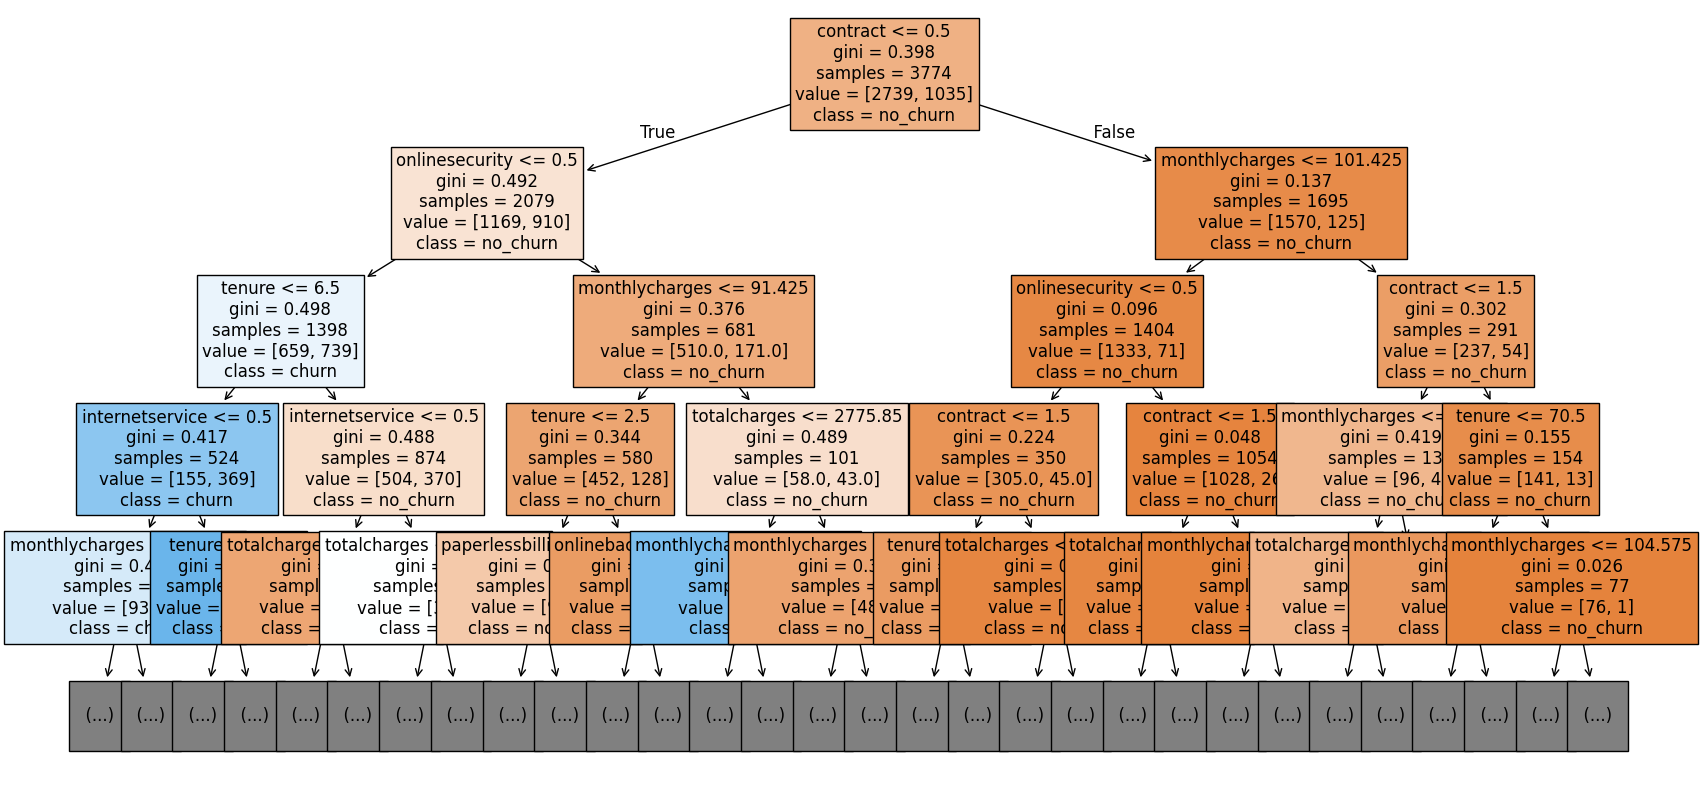

In [9]:
#3.3 visualize
"""
node is pure if it has only 1 class (churn or no-churn)
impurity is how mixed a node is (lower is more pure)
scikit uses Gini impurity
scikit tries every possible split on every feature and calculates
    Impurity decrease = Parent impurity – (weighted avg. child impurities)
    chooses the split that produces teh biggest drop in impurity
samples: how many data points (customers) reach this node
value: [no-churn, churn] majority determines the predicted class
"""
#text
r = tree.export_text(dt, feature_names=list(X_train.columns), max_depth=3)
print(r)

#graph
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(20, 10))
tree.plot_tree(
    dt,
    feature_names=X_train.columns,
    class_names=['no_churn', 'churn'],
    filled=True,
    max_depth=4,
    fontsize=12
)
plt.show()

In [10]:
#4 prune - ideal depth will give you highest val AUC
"""
Cost Complexity Pruning
Cost(tree) = Impurity(tree) + alpha * (num of leaves leaves)
impurity - how mixed the node is. total leaf impurity at that step
num of leaves tells complexity of tree
alpha - how much we pnalize complexity - optimal alpha gives bst validation AUC
dt = unpruned tree
cost_complexity_pruning_path: figures out all alpha values at which pruning would benefit tree structure
ccp_alphas - sorted alpha values fro smalles (no/low pruning) to largest (agressive pruning)
"""

#4.1 - get pruning path
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

#inpsect alpha values. show number of ways tree can be pruned (none to very pruned)
print(f"Top Pruning Paths. Total pruning steps: {len(ccp_alphas)}")
for i in range(min(10, len(ccp_alphas))):
    print(f"alpha: {ccp_alphas[i]:.6f},   total_impurity: {impurities[i]:.3f}")

#4.2 train a tree for each alpha
trees = []
print("\nTree size for each alpha")
for c in ccp_alphas:
    dt = DecisionTreeClassifier(ccp_alpha=c, random_state=1)
    dt.fit(X_train, y_train)
    trees.append(dt)

for c, t in zip(ccp_alphas, trees):
    print(f"alpha: {c:.6f},   nodes: {t.tree_.node_count}, leaves: {t.tree_.n_leaves}")

#4.3 evaluate each tree
val_scores = []
print("\nTree validation AUC")
for c, t in zip(ccp_alphas, trees):
    auc = roc_auc_score(y_val, t.predict_proba(X_val)[:,1])
    val_scores.append(auc)
    print(f"alpha: {c:.6f},   nodes: {t.tree_.node_count}, auc: {auc:.4f}")

best_idx = np.argmax(val_scores)
best_alpha = ccp_alphas[best_idx]
print("\nBest alpha:", best_alpha)
print("Best val AUC:", val_scores[best_idx])

Top Pruning Paths. Total pruning steps: 295
alpha: 0.000000,   total_impurity: 0.002
alpha: 0.000088,   total_impurity: 0.002
alpha: 0.000088,   total_impurity: 0.002
alpha: 0.000099,   total_impurity: 0.002
alpha: 0.000112,   total_impurity: 0.002
alpha: 0.000127,   total_impurity: 0.003
alpha: 0.000132,   total_impurity: 0.003
alpha: 0.000132,   total_impurity: 0.003
alpha: 0.000132,   total_impurity: 0.003
alpha: 0.000163,   total_impurity: 0.004

Tree size for each alpha
alpha: 0.000000,   nodes: 1477, leaves: 739
alpha: 0.000088,   nodes: 1473, leaves: 737
alpha: 0.000088,   nodes: 1473, leaves: 737
alpha: 0.000099,   nodes: 1469, leaves: 735
alpha: 0.000112,   nodes: 1465, leaves: 733
alpha: 0.000127,   nodes: 1457, leaves: 729
alpha: 0.000132,   nodes: 1451, leaves: 726
alpha: 0.000132,   nodes: 1451, leaves: 726
alpha: 0.000132,   nodes: 1451, leaves: 726
alpha: 0.000163,   nodes: 1445, leaves: 723
alpha: 0.000168,   nodes: 1439, leaves: 720
alpha: 0.000171,   nodes: 1433, leav

Train accuracy: 0.811075781664017
Val accuracy:   0.7865591397849462

Train ROC AUC: 0.8516119815229296
Val ROC AUC:   0.819670572238096

Top features:
contract            0.502294
onlinesecurity      0.150654
tenure              0.127863
internetservice     0.081976
monthlycharges      0.063886
totalcharges        0.056022
paperlessbilling    0.009103
onlinebackup        0.008202
partner             0.000000
gender              0.000000
seniorcitizen       0.000000
deviceprotection    0.000000
dependents          0.000000
phoneservice        0.000000
multiplelines       0.000000
streamingmovies     0.000000
streamingtv         0.000000
techsupport         0.000000
paymentmethod       0.000000
dtype: float64

Graphs
|--- contract <= 0.50
|   |--- onlinesecurity <= 0.50
|   |   |--- tenure <= 6.50
|   |   |   |--- internetservice <= 0.50
|   |   |   |   |--- monthlycharges <= 55.23
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- monthlycharges >  55.23
|   |   |   |   |   |--- cl

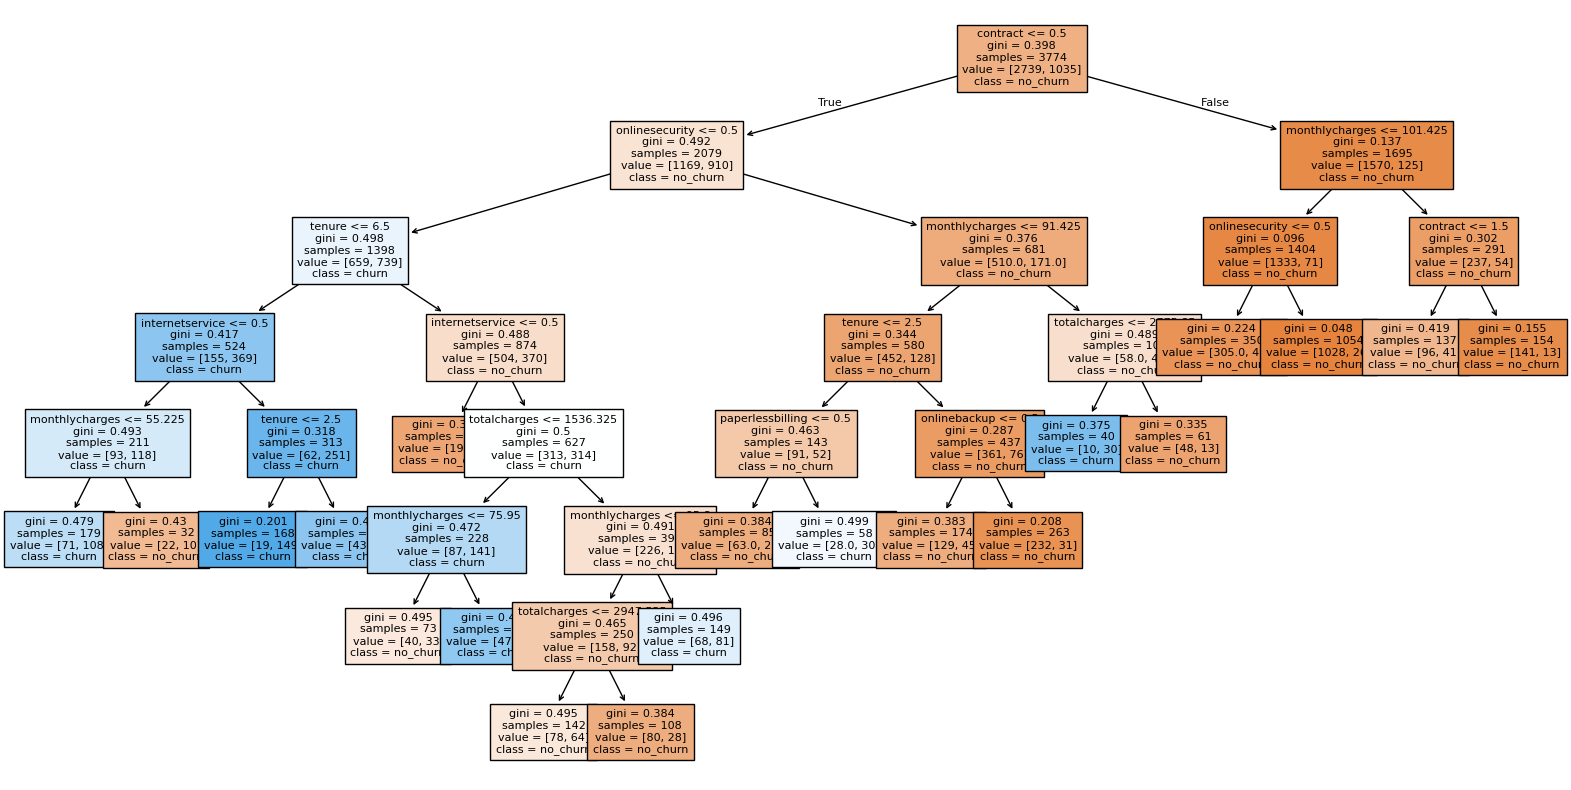

In [11]:
#4.4 train final pruned tree
dt_pruned = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=1)
dt_pruned.fit(X_train, y_train)

# predictions (class labels)
y_pred_train = dt_pruned.predict(X_train)
y_pred_val   = dt_pruned.predict(X_val)

# probability predictions (for ROC AUC)
y_proba_train = dt_pruned.predict_proba(X_train)[:, 1]
y_proba_val   = dt_pruned.predict_proba(X_val)[:, 1]

print("Train accuracy:", accuracy_score(y_train, y_pred_train))
print("Val accuracy:  ", accuracy_score(y_val, y_pred_val))

print("\nTrain ROC AUC:", roc_auc_score(y_train, y_proba_train))
print("Val ROC AUC:  ", roc_auc_score(y_val, y_proba_val))

#feature imporatance - how much each feature helped reduce impurity (Gini) across the tree
fi = pd.Series(dt_pruned.feature_importances_, index=X_train.columns)
print("\nTop features:")
print(fi.sort_values(ascending=False))

#4.5 visualize
#text
print("\nGraphs")
print(export_text(dt_pruned, feature_names=list(X_train.columns), max_depth=20))

#graph
plt.figure(figsize=(20,10))
tree.plot_tree(dt_pruned,
               feature_names=X_train.columns,
               class_names=['no_churn','churn'],
               filled=True,
               max_depth=7,
               fontsize=8
              )
plt.show()

In [12]:
#5 Manual decision tree
"""
sklearn  repeats this process recursively
For every node:
1. compute impurity
2. try every possible split for every feature
3. compute child impurities (how mixed with churn vs non-churn)
4. comuted weighted impurites (impurites of children after split. take into acount how man samples went left vs right)
5. compute impurity reduction
6. pick split with largest impurity reduction
7. recurse - after finding best root, split to build left and right subtrees
8. at each node check to see if split should stop
    is node pure - all samples are the same class
    has max depth been reached
    is impurity reduction too small - spliting doesnt lead to improvement
9. prune
"""
#5.1 Compute Gini impurity at root (start with contract since we know it will be the feature chosen as root)
print("Churn Distribution for 'contract'")
print(df_clean['churn'].value_counts())
print("\nChurn Distribution for 'contract'")
print(df_clean.groupby('contract')['churn'].value_counts())
print("\nCustomers per contract type")
print(df_clean['contract'].value_counts())

Churn Distribution for 'contract'
churn
0    5174
1    1869
Name: count, dtype: int64

Churn Distribution for 'contract'
contract        churn
month-to-month  0        2220
                1        1655
one_year        0        1307
                1         166
two_year        0        1647
                1          48
Name: count, dtype: int64

Customers per contract type
contract
month-to-month    3875
two_year          1695
one_year          1473
Name: count, dtype: int64


In [14]:
#5.2 compute first split - use gini helper function
y_root = df_clean['churn']
gini_root = gini(y_root)
n_root = len(y_root)

#5.2.1 compute root impurity = 1 - (p0^2 + p1^2)
print("Root Node")
print(f"Total samples: {n_root}")
print(df_clean['churn'].value_counts())
print(f"Gini(root): {gini_root:.4f}\n")

#5.2.2 define left(month-to-month)/right(contracts) groups for the contract split
left_mask  = df_clean['contract'] == 'month-to-month' #create boolean series for month-to-month/contract
right_mask = ~left_mask #right mask: not month-to-month, ie 1 or 2 yr contract

#extract chrun labels for child nodes
y_left = df_clean.loc[left_mask, 'churn']
y_right = df_clean.loc[right_mask, 'churn']

#compute impurities of child nodes
gini_left = gini(y_left)
gini_right = gini(y_right)

#count customers in each branch
n_left = len(y_left)
n_right = len(y_right)

#calculate proportion of customers who split in each direction
w_left = n_left / n_root
w_right = n_right / n_root

#split
print("\nSplit: contract = month-to-month vs (one_year + two_year)")
#left branch: month-to-month
print(f"Left (month-to-month):    n={n_left}")
print(y_left.value_counts())
print(f"Gini(left):  {gini_left:.4f}\n")

#right branch: 1,2 yr contracts
print(f"Right (one_year/two_year): n={n_right}")
print(y_right.value_counts())
print(f"Gini(right): {gini_right:.4f}\n")

Root Node
Total samples: 7043
churn
0    5174
1    1869
Name: count, dtype: int64
Gini(root): 0.3899


Split: contract = month-to-month vs (one_year + two_year)
Left (month-to-month):    n=3875
churn
0    2220
1    1655
Name: count, dtype: int64
Gini(left):  0.4894

Right (one_year/two_year): n=3168
churn
0    2954
1     214
Name: count, dtype: int64
Gini(right): 0.1260



In [17]:
#5.3 evaluate
#formulas
gini_split = w_left * gini_left + w_right * gini_right
imp_reduction = gini_root - gini_split

#5.3.1 compute weighted gini for
print("\nWeighted child Gini:")
print(f"Gini_split = {w_left:.3f} * {gini_left:.4f} + {w_right:.3f} * {gini_right:.4f} = {gini_split:.4f}")

#5.3.2 compute impurity reduction
print(f"Impurity reduction = Gini(root) - Gini_split = {gini_root:.4f} - {gini_split:.4f} = {imp_reduction:.4f}")


Weighted child Gini:
Gini_split = 0.550 * 0.4894 + 0.450 * 0.1260 = 0.3259
Impurity reduction = Gini(root) - Gini_split = 0.3899 - 0.3259 = 0.0640
